# Семинар 8 - Сверточные нейронные сети (Convolution neural network)

In [ ]:
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

# Немного про свертки

за основу взят материал [dlschool](https://www.dlschool.org/)

In [ ]:
from PIL import Image
from math import ceil, sqrt
from math import floor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


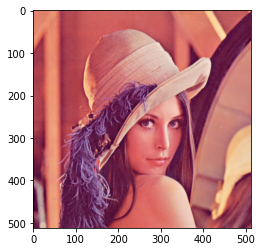

In [ ]:
img = Image.open('./gdrive/My Drive/Colab Notebooks/Семинар 8/Lenna.png')
pixels = img.load()

plt.imshow(img);

In [ ]:
def checkByte(a):
    if a > 255:
        a = 255
    if a < 0:
        a = 0
    return a
  

def conv(a, b):
  # размеры a и b совпадают
    sum = 0 
    # Ваш код здесь
    for i in range(len(a)):
      for j in range(len(a[0])):
        sum += a[i][j]*b[i][j]
    return sum

In [ ]:
filter = [ 
          # Ваш код здесь
          [-1, -1, -1],
          [10, 10, 10],
          [-1, -1, -1]
]

In [ ]:
imFinal = img.copy()
pixels2 = imFinal.load()

In [ ]:
np.sum(filter)

2

In [ ]:
div = 1 if np.sum(filter) == 0 else np.sum(filter)
div

2

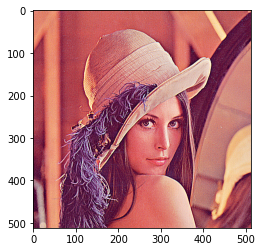

In [ ]:
Contrasted = img.copy()
pixels2 = Contrasted.load()


for i in range(floor(len(filter)/2), img.width - floor(len(filter)/2)):
    for j in range(floor(len(filter)/2), img.height - floor(len(filter)/2)):
        matrR = []
        matrG = []
        matrB = []
        for n in range(-floor(len(filter)/2), ceil(len(filter)/2)):
            rowR = []
            rowG = []
            rowB = []
            for m in range(-floor(len(filter)/2), ceil(len(filter)/2)):
                r, g, b = pixels[i + n, j + m]
                rowR.append(r)
                rowG.append(g)
                rowB.append(b)
            matrR.append(rowR)
            matrG.append(rowG)
            matrB.append(rowB)

        r = checkByte(int(conv(matrR, filter) / div))
        g = checkByte(int(conv(matrG, filter) / div))
        b = checkByte(int(conv(matrB, filter) / div))

        pixels2[i, j] = (r, g, b)

plt.imshow(Contrasted);

## Загрузим данные

In [ ]:
import torch
import torchvision

from torchvision import datasets,transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
trainset = datasets.CIFAR10('~/.pytorch/cifar_data/', train = True, download = True)
testset = datasets.CIFAR10('~/.pytorch/cifar_data/', train = False, download = True)

Extracting /root/.pytorch/cifar_data/cifar-10-python.tar.gz to /root/.pytorch/cifar_data/
Files already downloaded and verified


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='~/.pytorch/cifar_data/', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/.pytorch/cifar_data/', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_names = trainset.classes
num_classes = len(trainset.classes)

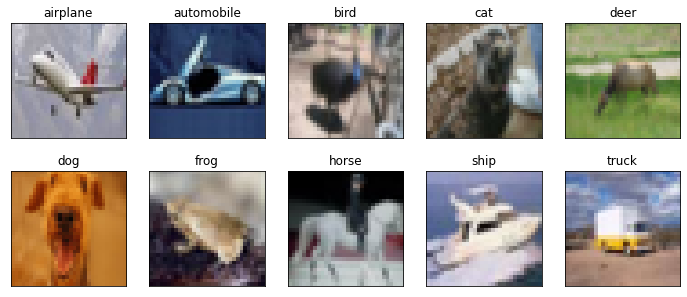

In [ ]:
# Сгенерируем случаные примеры для каждого класса
fig = plt.figure(figsize=(12,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.array(trainset.targets)==i)[0]
    
    features_idx = trainset.data[idx,::]
    
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [ ]:
trainset.data.shape, testset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Парочка метрик

In [ ]:
def accuracy_score(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [ ]:
def accuracy_score_by_class(model, testloader):  
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            class_names[i], 100 * class_correct[i] / class_total[i]))

# Слои нейронной сети

## Контейнеры

| Контейнер | Описание |
| --- | --- |
| Module | Base class for all neural network modules |
| Sequential | A sequential container |
| ModuleList | Holds submodules in a list |
| ModuleDict | Holds submodules in a dictionary |
| ParameterList | Holds parameters in a list |
| ParameterDict | Holds parameters in a dictionary |


## Линейные слои

Параметры:

| Параметр | Описание |
| --- | --- |
| in_features | размер входа |
| out_features | размер выхода |
| bias | создавать ли параметр сдвига |

In [ ]:
Linear = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = Linear(input)
print(output.size())

torch.Size([128, 30])


In [ ]:
print(Linear.in_features)
print(Linear.bias)
print(Linear.weight)

20
Parameter containing:
tensor([-0.0148,  0.0526, -0.1761, -0.2067,  0.1522, -0.0044, -0.0038, -0.1165,
        -0.2154,  0.1532, -0.1918,  0.1502, -0.0813, -0.0921,  0.1647,  0.0848,
         0.1068, -0.2123, -0.0329, -0.0362,  0.1120, -0.0354, -0.0204, -0.1757,
        -0.1248,  0.2153,  0.0090,  0.0574,  0.0358, -0.1441],
       requires_grad=True)
Parameter containing:
tensor([[-0.1838,  0.0805,  0.0699,  0.0697,  0.1898, -0.1211, -0.1984,  0.0126,
          0.0904,  0.0217, -0.1688, -0.1353,  0.0516,  0.0080, -0.0293,  0.0254,
         -0.0819, -0.1750, -0.0340,  0.0518],
        [ 0.2146, -0.2028, -0.2225,  0.1618,  0.1092,  0.1351, -0.1096,  0.0598,
         -0.0639,  0.1156,  0.1730,  0.0740, -0.1642,  0.0997, -0.0152,  0.1674,
          0.1846, -0.0157, -0.2036, -0.1787],
        [ 0.1252,  0.1734, -0.1143,  0.0659, -0.1218,  0.0952, -0.0306,  0.2064,
         -0.0023,  0.1246, -0.0396, -0.1196, -0.1797, -0.1276, -0.1315, -0.0683,
          0.0622, -0.1312, -0.0944, -0.0823],

## Сверточные слои

![picture](https://drive.google.com/uc?export=view&id=1WLEAyFi_Kbz0nobb83gBG55fX9eSGKoO)

Параметры:

| Параметр | Описание |
| --- | --- |
| in_channels | размер входа |
| out_channels | размер выхода |
| kernel_size | размер ядра |
| --- | --- |
| stride | шаг |
| padding | отступ |
| padding_mode | тип заполнения |
| dilation | разреженность |


[Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [ ]:
Conv1d = nn.Conv1d(3, 6, 4, stride=1, padding=0)
input = torch.randn(5, 3, 5)
output = Conv1d(input)
output.shape

torch.Size([5, 6, 2])

In [ ]:
Conv2d = nn.Conv2d(16, 6, (3, 5), stride=(1, 3), padding=(2, 1), dilation=(3, 1))
input = torch.randn(5, 16, 50, 100)
output = Conv2d(input)
# Ваш код здесь

In [ ]:
Conv3d = nn.Conv3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(4, 2, 0))
input = torch.randn(20, 16, 10, 50, 100)
output = Conv3d(input)
output.shape

torch.Size([20, 33, 8, 50, 99])

## Cлои объединения (pooling)
![picture](https://drive.google.com/uc?export=view&id=1YIH4ZhcBb2K1hKNFL_6B9NvPk7beufKU)

Параметры:

| Параметр | Описание |
| --- | --- |
| kernel_size | размер ядра |
| --- | --- |
| stride | шаг |
| padding | отступ |
| dilation | разреженность |

In [ ]:
MaxPool2d = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = MaxPool2d(input)
output.shape

torch.Size([20, 16, 24, 31])

In [ ]:
AvgPool2d = nn.AvgPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = AvgPool2d(input)
output.shape

torch.Size([20, 16, 24, 31])

## Нормализация (Batch Norm)
[Статейка](https://arxiv.org/abs/1502.03167)


$y= \frac{x−E[x]}{\sqrt{Var[x]+ϵ}}*γ+β$


Параметры:

| Параметр | Описание |
| --- | --- |
| num_features | размер входа |
| --- | --- |
| momentum | параметр вычисления моментов |
| affine | обучение |

In [ ]:
BatchNorm2d = nn.BatchNorm2d(100)
# Without Learnable Parameters
BatchNorm2d = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = BatchNorm2d(input)
output.shape

torch.Size([20, 100, 35, 45])

## Cлои исключения (dropout)

[Статейка](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

![picture](https://drive.google.com/uc?export=view&id=1Mg9mDpV8ZJryr5mQFz8LE8Fr5urxyH-n)

Параметры:

| Параметр | Описание |
| --- | --- |
| p | вероятность применения |
| inplace | менять ли входное значение |

In [ ]:
Dropout2d = nn.Dropout2d(p=0.2)
input = torch.randn(20, 16, 32, 32)
output = Dropout2d(input)
output.shape

torch.Size([20, 16, 32, 32])

# Построение сверточной нейронной сети

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(16 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        # Ваш код здесь
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(-1, self.num_flat_features(x))
        # print(x.shape)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)

net = Net()

## Параметры модели

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
from torchsummary import summary

summary(net, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
            Conv2d-4           [-1, 16, 10, 10]           2,416
            Linear-5                  [-1, 256]         409,856
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                  [-1, 128]          32,896
            Linear-8                   [-1, 10]           1,290
Total params: 447,438
Trainable params: 447,438
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 1.71
Estimated Total Size (MB): 1.79
----------------------------------------------------------------


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[2].size())

14
torch.Size([16, 6, 5, 5])


## Обучим модель! 

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [ ]:
net.to(DEVICE)

learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for i, epoch in enumerate(range(5)):  # loop over the dataset multiple times

    for j, data in (enumerate(trainloader, 0)):
        
        inputs, labels = data
        # Ваш код здесь
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if j % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, loss.item()))
    
print('Finished Training')

[1,    20] loss: 1.874
[1,    40] loss: 1.921
[1,    60] loss: 1.864
[1,    80] loss: 1.842
[1,   100] loss: 1.859
[1,   120] loss: 1.835
[1,   140] loss: 1.904
[1,   160] loss: 1.862
[1,   180] loss: 1.974
[1,   200] loss: 1.895
[1,   220] loss: 1.853
[1,   240] loss: 1.871
[2,    20] loss: 1.815
[2,    40] loss: 1.791
[2,    60] loss: 1.853
[2,    80] loss: 1.830
[2,   100] loss: 1.768
[2,   120] loss: 1.761
[2,   140] loss: 1.839
[2,   160] loss: 1.796
[2,   180] loss: 1.851
[2,   200] loss: 1.861
[2,   220] loss: 1.885
[2,   240] loss: 1.846
[3,    20] loss: 1.796
[3,    40] loss: 1.791
[3,    60] loss: 1.819
[3,    80] loss: 1.781
[3,   100] loss: 1.793
[3,   120] loss: 1.838
[3,   140] loss: 1.805
[3,   160] loss: 1.788
[3,   180] loss: 1.842
[3,   200] loss: 1.819
[3,   220] loss: 1.845
[3,   240] loss: 1.822
[4,    20] loss: 1.742
[4,    40] loss: 1.828
[4,    60] loss: 1.798
[4,    80] loss: 1.768
[4,   100] loss: 1.842
[4,   120] loss: 1.813
[4,   140] loss: 1.790
[4,   160] 

In [ ]:
accuracy_score(net.to('cpu'), testloader)
print('='*50)
accuracy_score_by_class(net.to('cpu'), testloader)

Accuracy of the network on the 10000 test images: 61 %
Accuracy of airplane : 63 %
Accuracy of automobile : 88 %
Accuracy of  bird : 26 %
Accuracy of   cat : 56 %
Accuracy of  deer : 48 %
Accuracy of   dog : 33 %
Accuracy of  frog : 68 %
Accuracy of horse : 87 %
Accuracy of  ship : 80 %
Accuracy of truck : 71 %


## Сохранение и загрузка модели

#### Сохранение и... 

In [ ]:
torch.save(net.state_dict(), './net.pth')

#### ... загрузка

In [ ]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('./net.pth'))

<All keys matched successfully>

In [ ]:
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
accuracy_score(loaded_model, testloader)
print('='*50)
accuracy_score_by_class(loaded_model, testloader)

Accuracy of the network on the 10000 test images: 61 %
Accuracy of airplane : 59 %
Accuracy of automobile : 88 %
Accuracy of  bird : 26 %
Accuracy of   cat : 56 %
Accuracy of  deer : 51 %
Accuracy of   dog : 33 %
Accuracy of  frog : 72 %
Accuracy of horse : 87 %
Accuracy of  ship : 76 %
Accuracy of truck : 71 %


## Как нейронка видит котиков

True class: cat
Predicted: bird with prob: 1.0


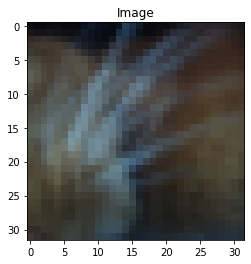

In [ ]:
idx = np.random.choice(np.where(np.array(testset.targets)==3)[0])

im = np.transpose(testset.data[idx],(0,1,2))

subset_indices = [idx] # select your indices here as a list
subset = torch.utils.data.Subset(testset, subset_indices)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=10, num_workers=0, shuffle=False)

with torch.no_grad():
    for data in testloader_subset:
        image, label = data
        output = loaded_model(image)

print(f'True class: {class_names[testset.targets[idx]]}')
print(f'Predicted: {class_names[output.argmax().item()]} with prob: {np.round(output.max().item(), decimals=4)}')
plt.title('Image')
plt.imshow(im)
plt.show()

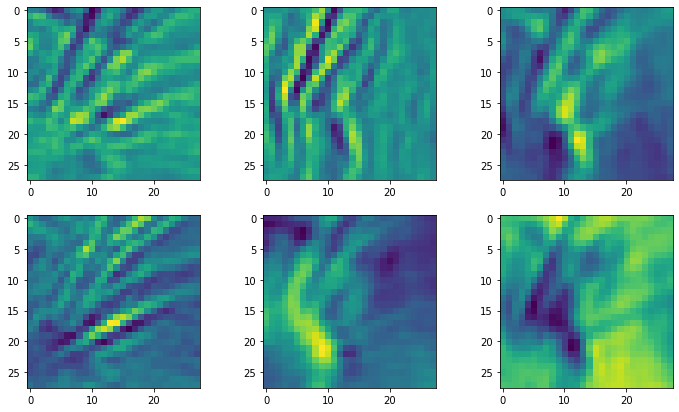

In [ ]:
fig = plt.figure(figsize=(12, 7))

masks = loaded_model.conv1(image)[0]
for i, mask in enumerate(masks):
    plt.subplot(2, 3, i+1)
    plt.imshow(mask.detach().numpy())
plt.show()

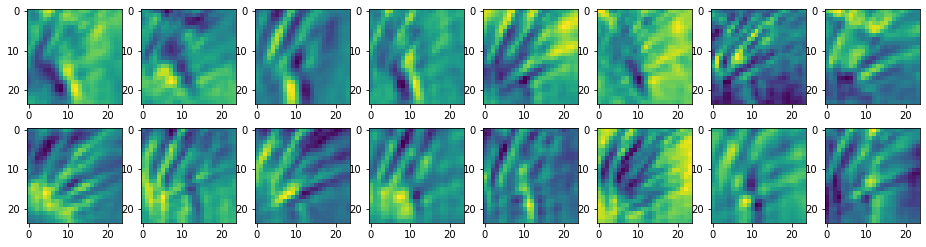

In [ ]:
fig = plt.figure(figsize=(16, 4))

masks = loaded_model.conv2(loaded_model.conv1(image))[0]

for i, mask in enumerate(masks):
    plt.subplot(2, 8, i+1)
    plt.imshow(mask.detach().numpy())
plt.show()

## Предобученные сети

Подробнее в [документации](https://pytorch.org/docs/stable/torchvision/models.html) 

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Freeze model weights
# Ваш код здесь
for param in resnet18.parameters():
  param.requires_grad = False

In [ ]:
resnet18.fc

Sequential(
  (0): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
# Add on classifier
# Ваш код здесь

fc_10 = torch.nn.Sequential(torch.nn.Linear(512, 10))
resnet18.fc = fc_10


In [ ]:
for param in resnet18.fc.parameters():
  param.requires_grad = True

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.00001)

In [ ]:
resnet18.to(DEVICE)

for i, epoch in enumerate(range(2)):  # loop over the dataset multiple times

    for j, data in (enumerate(trainloader, 0)):
        
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        # print(type(inputs))
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if j % 100 == 99:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, loss.item()))
    
print('Finished Training')

[1,   100] loss: 2.294
[1,   200] loss: 2.304
[2,   100] loss: 2.253
[2,   200] loss: 2.308
Finished Training


In [ ]:
accuracy_score(resnet18.to('cpu'), testloader)
print('='*50)
accuracy_score_by_class(resnet18.to('cpu'), testloader)

Accuracy of the network on the 10000 test images: 18 %
Accuracy of airplane :  9 %
Accuracy of automobile : 11 %
Accuracy of  bird : 10 %
Accuracy of   cat : 21 %
Accuracy of  deer : 14 %
Accuracy of   dog : 20 %
Accuracy of  frog : 27 %
Accuracy of horse : 12 %
Accuracy of  ship : 12 %
Accuracy of truck : 14 %


In [ ]:
# torch.save(resnet18.state_dict(), './resnet.pth')

In [ ]:
loaded_resnet = resnet18
loaded_resnet.load_state_dict(torch.load('./resnet.pth'))

In [ ]:
accuracy_score(loaded_resnet, testloader)
print('='*50)
accuracy_score_by_class(loaded_resnet, testloader)